In [0]:
# DATA COllECTION
# ED & LY : PROJECT LOCATION (500 each?) 
# KN : URA DATA (DONE)

# DATA PREPROCESSING
# KN: Combining all ura data (done)
# KN : One Hot Encoding for district, One Hot Encoding for bedrooms 
# KN : Refactor code to display data Prepocessing Step
# LY : 1) Number of bedroom demand, avg price-psf by district to display in follium
# KN : Combining bedroom demand & URA data set together
# 
# Models
# ED: Root Mean Squared Error
# ED: KNN
# LY: Ridge regression
# KN: XGBoost
# LY: Display of val accuracy vs test accuracy (Graph display follow lab)

# Additional
# Decision Tree Model, Neural network mdoel



# Codes
# Cleaning project property codes
# precondition: DF need Project name to use this code

# dict_project={}
# for index, row in df.iterrows():
#     try:
#         dict_project[row['Building/Project Name']]
#     except KeyError:
#         if((row['lat']<1.1)or(row['lat']>1.5)):
#             print(row['lat'],row['long'],row['Building/Project Name'])
#             dict_project[row['Building/Project Name']]=1
#         if((row['long']<103)or(row['long']>104)):
#             print(row['lat'],row['long'],row['Building/Project Name'])
#             dict_project[row['Building/Project Name']]=1

# Printing rows with significant values of bedroom
# # for index, row in df.iterrows():
#     if(row['No. of Bedroom(for Non-Landed Only)']=='03'):
#         print(row)
#     if(row['No. of Bedroom(for Non-Landed Only)']=='8'):
#         print(row)

In [5]:
import pandas as pd
import math
import numpy as np
from sklearn import preprocessing, svm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from datetime import datetime
from IPython.display import display, HTML
from matplotlib import colors
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# SMALLER DATASET JUST FOR TESTING
# df=pd.read_csv('ura_1_5.csv',skiprows=1)
# df=df[:-6] #Get rid of tail non-data description
# display(df.tail(2))

# Large Dataset
df_1_5=pd.read_csv('ura_1_5.csv',skiprows=1)
df_1_5=df_1_5[:-6] #Get rid of tail non-data description
# display(df_1_5.tail(2))

df_6_10=pd.read_csv('ura_6_10.csv',skiprows=1)
df_6_10=df_6_10[:-6] #Get rid of tail non-data description
# display(df_6_10.tail(2))

df_11_15=pd.read_csv('ura_11_15.csv',skiprows=1)
df_11_15=df_11_15[:-6] #Get rid of tail non-data description
# display(df_11_15.tail(2))

df_16_20=pd.read_csv('ura_16_20.csv',skiprows=1)
df_16_20=df_16_20[:-6] #Get rid of tail non-data description
# display(df_16_20.tail(2))

df_21_26=pd.read_csv('ura_21_26.csv',skiprows=1)
df_21_26=df_21_26[:-6] #Get rid of tail non-data description
# display(df_21_26.tail(2))

df_27_28=pd.read_csv('ura_27_28.csv',skiprows=1)
df_27_28=df_27_28[:-6] #Get rid of tail non-data description
# display(df_27_28.tail(2))

print("====================All URA Dataframe=======================")
df = pd.concat([df_1_5, df_6_10,df_11_15,df_16_20,df_21_26,df_27_28], ignore_index=True)
display(df.tail(2))

df_dict=pd.read_csv('property_project.csv')
df_dict=df_dict[['address','lat','long']]
df_dict=df_dict.set_index('address').to_dict()
df_dict['lat']['JI XIANG COURT']

dates_dict={
    "Jan": 1,
    "Feb": 2,
    "Mar": 3,
    "Apr": 4,
    "May": 5,
    "Jun":6,
    "Jul":7,
    "Aug":8,
    "Sep":9,
    "Oct":10,
    "Nov":11,
    "Dec":12    
}

# Preprocessing
# -Converting Floor Area(1400 to 1500 -> 1450)
# -Monthly rental/ sqft> Monthly rental Psf
# -Building/Project Name , District -> lat, long
# -Lease Commencement Date -> date
def g(x):
    if(x=='ANGULLIA PARK RESIDENCES @ ORCHARD'):
        return 'ANGULLIA PARK RESIDENCES@ORCHARD'
    return x
df['Building/Project Name'] = df['Building/Project Name'].apply(g)
    
    
def f(x):
    try:
        return sum([int(item) for item in str(x).split(' to ')])/2
    except:
        return 0
df['Floor Area (sq ft)'] = df['Floor Area (sq ft)'].apply(f)
df['Monthly Rent/ psf']=df['Monthly Gross Rent($)']/df['Floor Area (sq ft)']
df['lat']=df['Building/Project Name'].apply(lambda x:df_dict['lat'][x])
df['long']=df['Building/Project Name'].apply(lambda x:df_dict['long'][x])
def g(x):
    m,y=x.split('-')
    return pd.Timestamp(int(y),dates_dict[m],1).toordinal()
df['Lease Commencement Date']=df['Lease Commencement Date'].apply(g).astype(float)
# # Remove missing bedroom data
df['No. of Bedroom(for Non-Landed Only)']=df['No. of Bedroom(for Non-Landed Only)'].replace('na*',np.NaN)
df=df.dropna()
df = df.drop(df[df["Floor Area (sq ft)"]<50].index)

# One Hot Encoding for Bed Room
df.rename(columns={'No. of Bedroom(for Non-Landed Only)':'no_bedroom'}, inplace=True)# Rename Bed Room

df = pd.concat([df,pd.get_dummies(df['no_bedroom'], prefix='no_bedroom')],axis=1)

# # consolidaiton of Data
df=df[['Monthly Gross Rent($)','Monthly Rent/ psf','Postal District','lat','long','no_bedroom','Floor Area (sq ft)','Lease Commencement Date','no_bedroom_1','no_bedroom_2','no_bedroom_3','no_bedroom_4','no_bedroom_5','no_bedroom_6','no_bedroom_8']]
df['no_bedroom']=df['no_bedroom'].astype(float)
df['Floor Area (sq ft)']=df['Floor Area (sq ft)'].astype(float)


# KN : One Hot Encoding for district, One Hot Encoding for bedrooms
# KN : Refactor code to display data Prepocessing Step
df=df.rename(index=str, columns={"Monthly Gross Rent($)": "monthly_gross_rent", "Monthly Rent/ psf": "monthly_rent_psf","Postal District":"district","lat": "lat","long": "long","no_bedroom": "no_bedroom","Floor Area (sq ft)": "floor_area","Lease Commencement Date": "date" })
print("====================Old Preprocessed Dataframe (name: df ->liyang has some dependencies #bedroom counts)=======================")
display(df.tail(3))

print("====================Preprocessed Dataframe (name: df_prep)=======================")
df_prep=df[['monthly_gross_rent','no_bedroom_1','no_bedroom_2','no_bedroom_3','no_bedroom_4','no_bedroom_5','no_bedroom_6','no_bedroom_8','lat','long','floor_area','date']]
display(df_prep.tail(3))


====================All URA Dataframe=======================


,S/N,Building/Project Name,Street Name,Postal District,Type,No. of Bedroom(for Non-Landed Only),Monthly Gross Rent($),Floor Area (sq ft),Lease Commencement Date
223714,4680,H2O RESIDENCES,FERNVALE LINK,28.0,Non-landed Properties,3,2700.0,1100 to 1200,Nov-2015
223715,4681,H2O RESIDENCES,FERNVALE LINK,28.0,Non-landed Properties,3,2500.0,1100 to 1200,Nov-2015


====================Old Preprocessed Dataframe (name: df ->liyang has some dependencies #bedroom counts)=======================


,monthly_gross_rent,monthly_rent_psf,district,lat,long,no_bedroom,floor_area,date,no_bedroom_1,no_bedroom_2,no_bedroom_3,no_bedroom_4,no_bedroom_5,no_bedroom_6,no_bedroom_8
223713,2400.0,2.823529,27.0,1.438604,103.831283,2.0,850.0,735903.0,0,1,0,0,0,0,0
223714,2700.0,2.347826,28.0,1.392766,103.879232,3.0,1150.0,735903.0,0,0,1,0,0,0,0
223715,2500.0,2.173913,28.0,1.392766,103.879232,3.0,1150.0,735903.0,0,0,1,0,0,0,0


====================Preprocessed Dataframe (name: df_prep)=======================


,monthly_gross_rent,no_bedroom_1,no_bedroom_2,no_bedroom_3,no_bedroom_4,no_bedroom_5,no_bedroom_6,no_bedroom_8,lat,long,floor_area,date
223713,2400.0,0,1,0,0,0,0,0,1.438604,103.831283,850.0,735903.0
223714,2700.0,0,0,1,0,0,0,0,1.392766,103.879232,1150.0,735903.0
223715,2500.0,0,0,1,0,0,0,0,1.392766,103.879232,1150.0,735903.0


Text(0.5,1,'monthly_rent_psf')

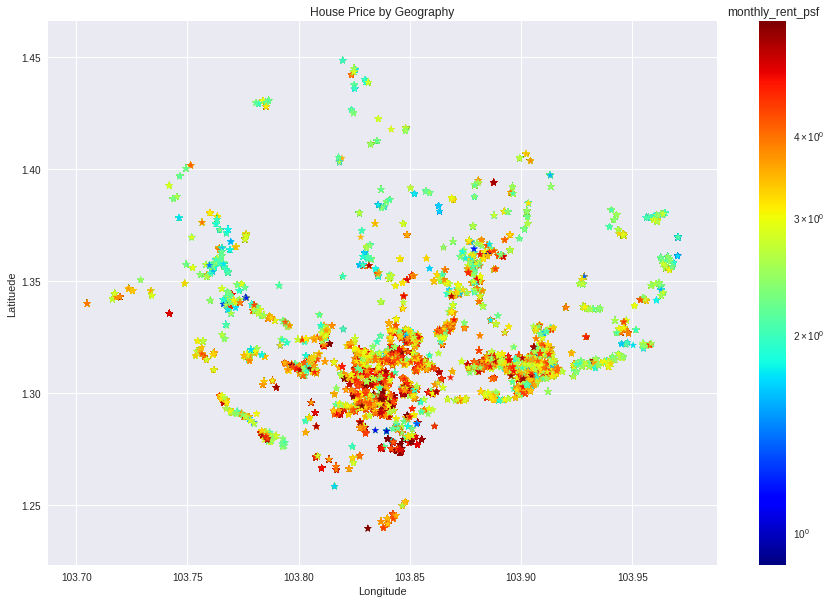

In [6]:
plt.figure(figsize=(15,10))
vmin = np.min(df.monthly_rent_psf)
vmax = np.max(df.monthly_rent_psf)
norm = colors.LogNorm(vmin*2,vmax/3)
plt.scatter(df.long,df.lat, marker='*',c=df.monthly_rent_psf,norm=norm,cmap='jet') 
plt.xlabel('Longitude')
plt.ylabel('Latituede')
plt.title('House Price by Geography')
clb = plt.colorbar() 
clb.ax.set_title('monthly_rent_psf')

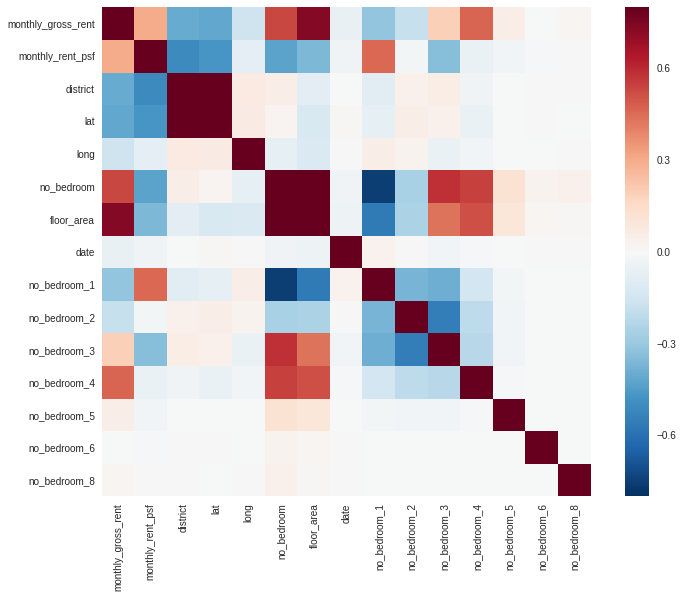

In [7]:
# Correlation Matrix Heatmap
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

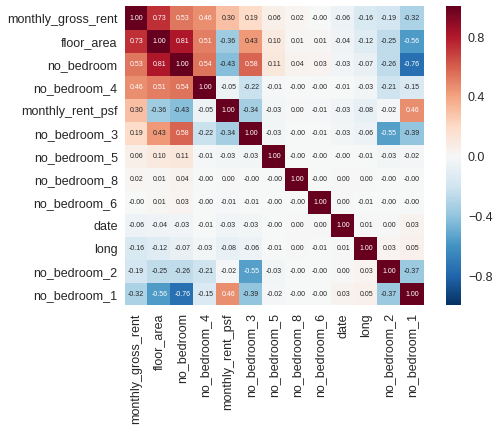

In [8]:
# Top 10 Heatmap
k = 13 #number of variables for heatmap
cols = corrmat.nlargest(k, 'monthly_gross_rent')['monthly_gross_rent'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 7}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [9]:
most_corr = pd.DataFrame(cols)
most_corr.columns = ['Most Correlated Features']
most_corr

,Most Correlated Features
0,monthly_gross_rent
1,floor_area
2,no_bedroom
3,no_bedroom_4
4,monthly_rent_psf
5,no_bedroom_3
6,no_bedroom_5
7,no_bedroom_8
8,no_bedroom_6
9,date


In [0]:
# Living Area vs Sale Price
# 'Monthly Gross Rent($)','Monthly Rent/ psf','lat','long','No. of Bedroom(for Non-Landed Only)','Floor Area (sq ft)','Lease Commencement Date'
# sns.jointplot(x=df['floor_area'], y=df['monthly_gross_rent'], kind='reg')
# sns.jointplot(x=df['floor_area'], y=df['monthly_rent_psf'], kind='reg')

In [11]:
# Count of project being rented,
# Count of Bed Room
# 

# Dataframe by Bedroom Sizes
bedroom_1=df[(df.no_bedroom>0.9)&(df.no_bedroom <1.1)]
bedroom_2=df[(df.no_bedroom>1.9)&(df.no_bedroom <2.1)]
bedroom_3=df[(df.no_bedroom>2.9)&(df.no_bedroom <3.1)]
bedroom_4=df[(df.no_bedroom>3.9)&(df.no_bedroom <4.1)]
bedroom_5=df[(df.no_bedroom>4.9)&(df.no_bedroom <5.1)]
bedroom_6=df[(df.no_bedroom>5.9)&(df.no_bedroom <6.1)]
bedroom_8=df[(df.no_bedroom>7.9)&(df.no_bedroom <8.1)]

bedroom_1_c=bedroom_1.count()
bedroom_2_c=bedroom_2.count()
bedroom_3_c=bedroom_3.count()
bedroom_4_c=bedroom_4.count()
bedroom_5_c=bedroom_5.count()
bedroom_6_c=bedroom_6.count()
bedroom_8_c=bedroom_8.count()

print("1_Bdrm: ",bedroom_1_c['no_bedroom'],"\n2_Bdrm: ", bedroom_2_c['no_bedroom'],"\n3_Bdrm: ",bedroom_3_c['no_bedroom'],"\n4_Bdrm: ",bedroom_4_c['no_bedroom'],"\n5_Bdrm: ",bedroom_5_c['no_bedroom'],"\n6_Bdrm: ",bedroom_6_c['no_bedroom'],"\n8_Bdrm: ",bedroom_8_c['no_bedroom'])
# display(bedroom_1.count())

# sns.jointplot(x=df['no_bedroom'], y=df['district'], kind='kde')
# sns.jointplot(x=df['lat'], y=df['long'], kind='kde')

1_Bdrm:  41507 
2_Bdrm:  68563 
3_Bdrm:  72493 
4_Bdrm:  15266 
5_Bdrm:  280 
6_Bdrm:  9 
8_Bdrm:  7


In [0]:
# LY : 1) Number of bedroom demand, avg price-psf by district to display in follium


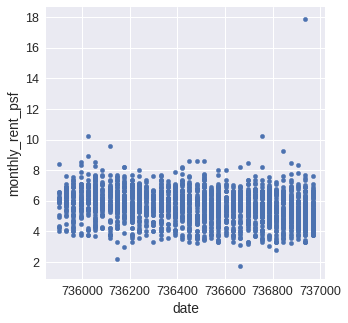

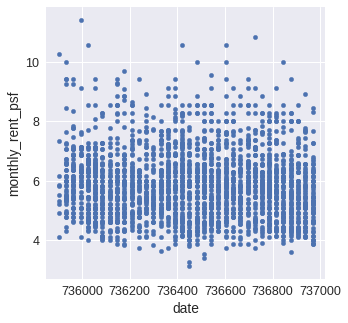

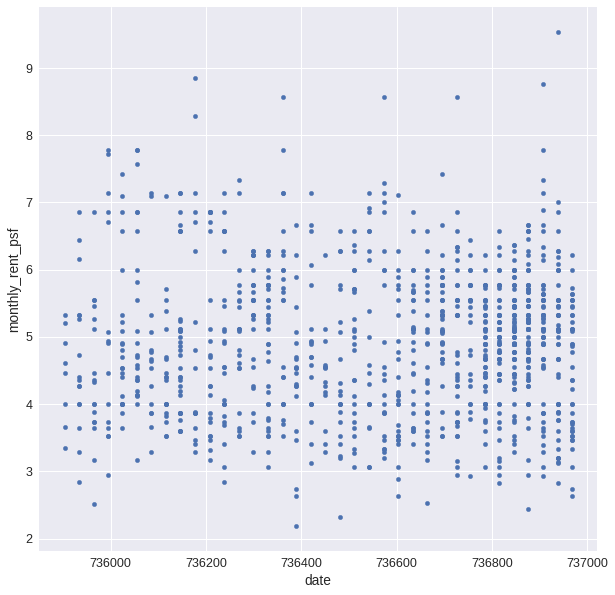

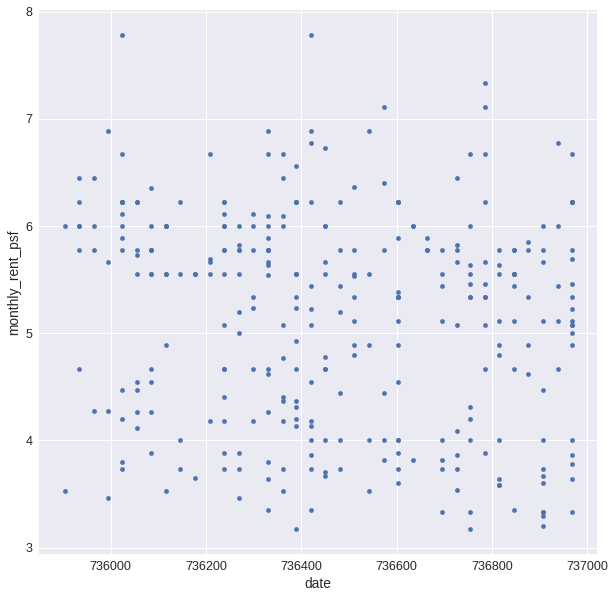

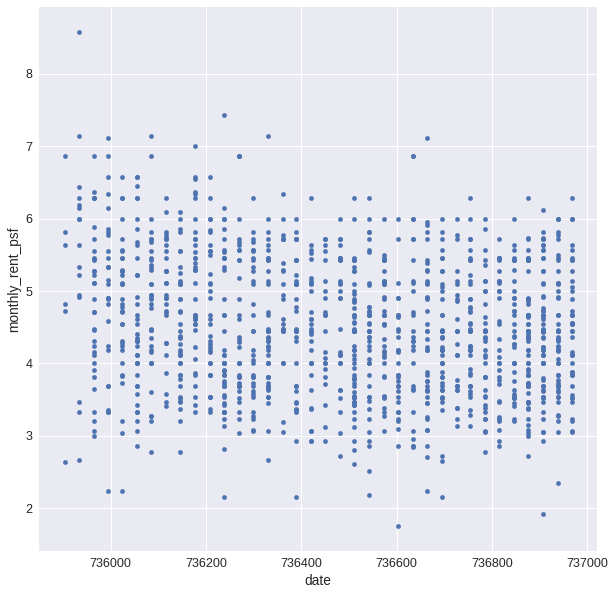

In [12]:
# Dataframe by bedroomsizes->to individual districts
# Visualise if dates has any correlation
bedroom_1[(bedroom_1.district>0.9)&(bedroom_1.district<1.1)].plot(x='date',y=('monthly_rent_psf'),figsize=(5,5),kind='scatter')
bedroom_1[(bedroom_1.district>1.9)&(bedroom_1.district<2.1)].plot(x='date',y=('monthly_rent_psf'),figsize=(5,5),kind='scatter')
bedroom_1[(bedroom_1.district>2.9)&(bedroom_1.district<3.1)].plot(x='date',y=('monthly_rent_psf'),figsize=(10,10),kind='scatter')
bedroom_1[(bedroom_1.district>3.9)&(bedroom_1.district<4.1)].plot(x='date',y=('monthly_rent_psf'),figsize=(10,10),kind='scatter')
bedroom_1[(bedroom_1.district>4.9)&(bedroom_1.district<5.1)].plot(x='date',y=('monthly_rent_psf'),figsize=(10,10),kind='scatter')

In [13]:
# Linear Model
X=np.array(df.drop(['monthly_gross_rent','monthly_rent_psf'],1))
Y=np.array(df['monthly_rent_psf'])
X = preprocessing.scale(X)
X_train, X_test, y_train, y_test= train_test_split(X,Y,test_size=0.2)
clf= LinearRegression()
clf.fit(X_train, y_train)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
accuracy=clf.score(X_test,y_test)
clf,accuracy

(158500, 13)
(39625, 13)
(158500,)
(39625,)


(LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
 0.5212345262248406)

In [17]:
# print(X_test.shape)
X_test_normalized = preprocessing.normalize(X_test)
y_predict_normalized = clf.predict(X_test_normalized)
y_predict_normalized = pd.DataFrame(y_predict_normalized)
# y_predict = clf.predict(X_test)
# y_predict = pd.DataFrame(y_predict)
# print(y_test.shape)
y_test_normalized = preprocessing.scale(y_test)
y_test_normalized = pd.DataFrame(y_test_normalized)
# y_test = pd.DataFrame(y_test)

squared_error = (y_predict_normalized - y_test_normalized)**(2)
# squared_error = (y_predict - y_test)**(2)
mse = squared_error.mean()
rmse = mse ** (1/2)
print(rmse)

# from sklearn.metrics import mean_squared_error, r2_score
#print("Mean squared error: %.2f"
#      % mean_squared_error(y_test, y_predict))

0    3.535498
dtype: float64


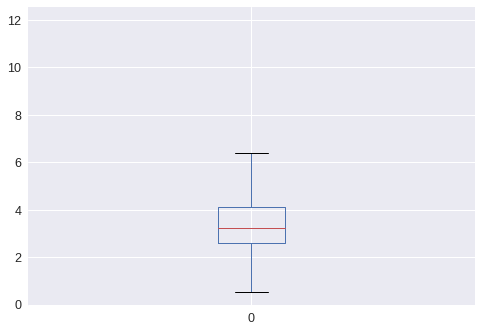

In [24]:
# fig, ax = plt.subplots() 
# print(y_test_normalized.shape)
# print(y_predict_normalized.shape)
# ax.boxplot([y_predict_normalized,y_test_normalized]) 
y_test.boxplot()


In [0]:
# Ridge, Lasso
# XGBoost
# NN

# ridge for lat long?

In [0]:
# DATA COllECTION
# ED & LY : PROJECT LOCATION (500 each?) 
# KN : URA DATA

# DATA PREPROCESSING
# KN : One Hot Encoding for district, One Hot Encoding for bedrooms
# KN : Refactor code to display data Prepocessing Step
# LY : 1) Number of bedroom demand, avg price-psf by district to display in follium
# KN : Combining bedroom demand & URA data set together
# 
# Models
# ED: Root Mean Squared Error
# ED: KNN
# LY: Ridge regression
# KN: XGBoost
# LY: Display of val accuracy vs test accuracy (Graph display follow lab)

# Additional
# Decision Tree Model, Neural network mdoel